In [44]:
import sys
import os

from dotenv import load_dotenv
sys.path.insert(0, os.path.abspath('../src'))
sys.path.insert(0, os.path.abspath('../src/agents'))
print(sys.path)

load_dotenv()

['/Users/I551385/Code/Personal/LLMsAgents-TextToSQL/src/agents', '/Users/I551385/Code/Personal/LLMsAgents-TextToSQL/src', '/Users/I551385/Code/Personal/LLMsAgents-TextToSQL/src/agents', '/Users/I551385/Code/Personal/LLMsAgents-TextToSQL/src', '/Users/I551385/Code/Personal/LLMsAgents-TextToSQL/src/agents', '/Users/I551385/Code/Personal/LLMsAgents-TextToSQL/src', '/Users/I551385/Code/Personal/LLMsAgents-TextToSQL/src/agents', '/Users/I551385/Code/Personal/LLMsAgents-TextToSQL/src', '/Users/I551385/Code/Personal/LLMsAgents-TextToSQL/src/agents', '/Users/I551385/Code/Personal/LLMsAgents-TextToSQL/src', '/Users/I551385/Code/Personal/LLMsAgents-TextToSQL/src/agents', '/Users/I551385/Code/Personal/LLMsAgents-TextToSQL/src', '/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/V

True

In [45]:
import pandas as pd

sample = pd.read_csv("../sample/dev_noisy.csv")
#sample = pd.read_csv("../sample/spider.csv")

sample.head()

,question_id,db_id,question,evidence,SQL,difficulty,noised
0,156,financial,Who is the owner of the account with the large...,NaN,SELECT T1.client_id FROM disp AS T1 INNER JOIN...,simple,True
1,1084,european_football_2,"Among the players born before the year 1986, h...",players born before the year 1986 refers to st...,SELECT COUNT(DISTINCT t1.player_name) FROM Pla...,challenging,True
2,347,card_games,Find all cards illustrated by Stephen Daniel a...,cards have missing or degraded properties and ...,"SELECT T1.id, T2.text, T1.hasContentWarning FR...",moderate,False
3,1391,student_club,What is the ratio between students majored in ...,"DIVDE(SUM(major_name = 'Finance'), SUM(major_n...",SELECT SUM(CASE WHEN major_name = 'igloo' THEN...,simple,True
4,733,superhero,How many gold-eyed superheroes did Marvel Comi...,gold-eyed refers to colour = 'Gold' where eye_...,SELECT COUNT(T1.id) FROM superhero AS T1 INNER...,moderate,True


In [46]:
sample.count()

question_id    200
db_id          200
question       200
evidence       185
SQL            200
difficulty     200
noised         200
dtype: int64

In [47]:
#from langchain_ollama.chat_models import ChatOllama
#from langchain_openai import ChatOpenAI
from langchain_openai import ChatOpenAI
from agents.feedback_agent import FeedbackAgent
from prompt_templates.feedback_agent import ONE_SHOT, TWO_SHOT, RULE_LEARNING, CHAIN_OF_THOUGHT, REPHRASE_AND_RESPOND, FIVE_SHOT
from gen_ai_hub.proxy.langchain.google_vertexai import init_chat_model as google_init_chat_model, ChatVertexAI
from gen_ai_hub.proxy.langchain.openai import ChatOpenAI 
from gen_ai_hub.proxy.langchain.amazon import ChatBedrock
from gen_ai_hub.proxy.langchain.amazon import init_chat_model as amazon_init_chat_model
from gen_ai_hub.proxy.langchain.init_models import init_llm

from gen_ai_hub.proxy.core.proxy_clients import get_proxy_client

model_name = "gemini-1.5-pro"
dataset_name = "bird-noisy-0-temp"
# llm = ChatOllama(model="mistral")
#llm = ChatOpenAI(model="gpt-4o-mini")
#model = 'anthropic--claude-3.5-sonnet'
#model_id = 'anthropic.claude-3-5-sonnet-20240620-v1:0'
#init_func = amazon_init_chat_model
#llm = init_llm(model, model_id=model_id, init_func=init_func)

llm = ChatVertexAI(proxy_model_name="gemini-1.5-pro", proxy_client=get_proxy_client("gen-ai-hub"), temperature=0)

#llm = ChatOpenAI(proxy_model_name=model_name, proxy_client=get_proxy_client("gen-ai-hub"), temperature=0)
agent = FeedbackAgent(llm=llm, template=TWO_SHOT)
model_type = "two_shot"

In [48]:
from tqdm.notebook import tqdm
import os

os.makedirs(f"./runs/feedback_agent/{dataset_name}/{model_name}", exist_ok=True)

try:
    ongoing_run = pd.read_csv(
        f"./runs/feedback_agent/{dataset_name}/{model_name}/{model_type}.csv"
    ).to_dict(orient="records")
    evaluation = ongoing_run
    start = len(ongoing_run)
except FileNotFoundError:
    evaluation = []
    start = 0

for row in tqdm(
    sample[start : len(sample)].itertuples(index=False),
    total=len(sample),
    initial=start,
    desc=f"Evaluating {model_name} on {dataset_name}: ",
):
    response = agent._evaluate_query(
        database=row.db_id, original_question=row.question, generated_sql_query=row.SQL, max_tokens=5000
    )
    if response:
        if "bird" in dataset_name:
            print(f"Difficulty: {row.difficulty} | Model Correct: {response["is_correct"] != row.noised}")
        else:
            print(f"Model Correct: {response['is_correct'] != row.noised}")
        is_correct = response["is_correct"]
        successful_run = response["query_result"] != "error"
        feedback = response["feedback"]
    else:
        is_correct = False
        successful_run = False
        feedback = "LLM Failure"

    if "bird" in dataset_name:
        evaluation.append({
            "question_id": row.question_id,
            "is_correct": is_correct != row.noised,
            "difficulty": row.difficulty,
            "successful_run": successful_run,
            "feedback": feedback,
            "noised": row.noised,
        })
    else:
        evaluation.append(
            {
                "question_id": row.question_id,
                "is_correct": is_correct,
                "successful_run": successful_run,
                "feedback": feedback,
                "noised": row.noised,
            }
        )

    df = pd.DataFrame(evaluation)
    df.to_csv(
        f"./runs/feedback_agent/{dataset_name}/{model_name}/{model_type}.csv",
        index=False,
    )

Evaluating gemini-1.5-pro on bird-noisy-0-temp:  48%|####8     | 97/200 [00:00<?, ?it/s]

text='\n            You are a database assistant responsible for verifying the accuracy of a generated SQL query.\n            Your task is to evaluate whether the results of the query answer the original question.\n            As input, you will receive the following information:\n            \n            {\n                "original_question": "The question that the SQL query is supposed to answer.",\n                "database": "The name of the database that the query is executed on.",\n                "generated_sql_query": "The SQL query that was generated by the text-to-SQL model.",\n                "query_result": "The first 20 elements of the result of the query. If the result is longer, show the first 10 and last 10 elements separated by ..."\n            }\n\n\n            -------------------------------------------------------------------------------\n\n            Here\'s the process you will follow:\n\n\n            Steps to Perform:\n            Evaluation: Compare the r

KeyboardInterrupt: 

In [ ]:
successful_runs_df = df[df["successful_run"]]

accuracy = successful_runs_df["is_correct"].mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 80.90%


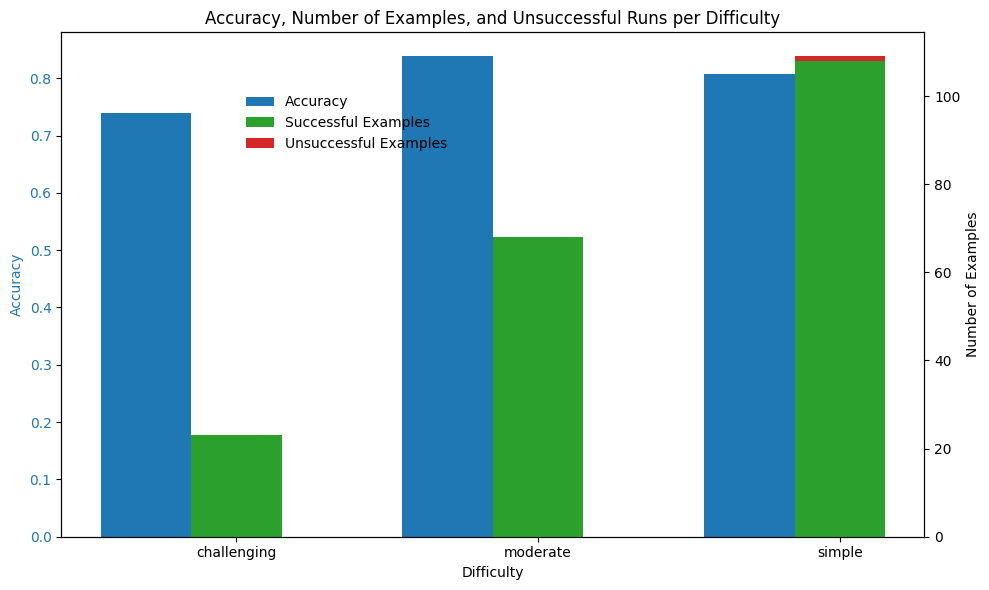

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

if "bird" in dataset_name:
    # Ensure all indices align with sorted difficulties
    difficulty_order = sorted(df["difficulty"].unique())

    # Calculate metrics, ensuring alignment
    accuracy_per_difficulty = (
        df.groupby("difficulty")["is_correct"]
        .mean()
        .reindex(difficulty_order, fill_value=0)
    )
    successful_examples = (
        df[df["successful_run"] == True]["difficulty"]
        .value_counts()
        .reindex(difficulty_order, fill_value=0)
    )
    unsuccessful_examples = (
        df[df["successful_run"] == False]["difficulty"]
        .value_counts()
        .reindex(difficulty_order, fill_value=0)
    )

    # Calculate total examples for consistency (or use successful + unsuccessful)
    examples_per_difficulty = successful_examples + unsuccessful_examples

    fig, ax1 = plt.subplots(figsize=(10, 6))  # Adjust figure size if needed

    # Plot accuracy per difficulty
    color = "tab:blue"
    ax1.set_xlabel("Difficulty")
    ax1.set_ylabel("Accuracy", color=color)
    ax1.bar(
        difficulty_order,
        accuracy_per_difficulty,
        color=color,
        label="Accuracy",
        width=0.3,
        align="center",
    )
    ax1.tick_params(axis="y", labelcolor=color)

    # Create a secondary y-axis to plot examples
    ax2 = ax1.twinx()
    ax2.set_ylabel("Number of Examples")

    # Plot examples and unsuccessful runs per difficulty
    width = 0.3  # Adjust bar width
    positions = range(len(difficulty_order))  # Shared x-axis positions

    # Stacked bar: successful and unsuccessful runs
    ax2.bar(
        [p + width for p in positions],
        successful_examples,
        color="tab:green",
        label="Successful Examples",
        width=width,
        align="center",
    )
    ax2.bar(
        [p + width for p in positions],
        unsuccessful_examples,
        bottom=successful_examples,
        color="tab:red",
        label="Unsuccessful Examples",
        width=width,
        align="center",
    )

    # Customize tick positions and labels
    ax1.set_xticks([p + width for p in positions])
    ax1.set_xticklabels(difficulty_order)

    ax1.grid(False)
    ax2.grid(False)

    # Adjust legend placement
    fig.legend(
        loc="upper left",
        bbox_to_anchor=(0.2, 0.9),
        bbox_transform=ax1.transAxes,
        frameon=False,
    )

    # Add title
    plt.title("Accuracy, Number of Examples, and Unsuccessful Runs per Difficulty")

    # Save the figure
    fig.savefig(f"runs/feedback_agent/{dataset_name}/{model_name}/{model_type}.png")

    fig.tight_layout()
    plt.show()

Accuracy: 80.90%
Proportion of successful runs: 0.99
Combined Metric: 0.90


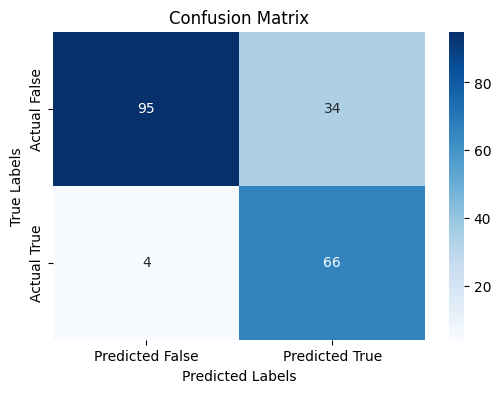

Confusion Matrix:
[[95, 34], [4, 66]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(f"./runs/feedback_agent/{dataset_name}/{model_name}/{model_type}.csv")

successful_runs_df = df[df['successful_run']]

# Calculate the accuracy using is_correct
accuracy = successful_runs_df['is_correct'].mean() * 100
print(f"Accuracy: {accuracy:.2f}%")

# Calculate the proportion of successful runs
successful_runs_ratio = df['successful_run'].mean()
print(f"Proportion of successful runs: {successful_runs_ratio:.2f}")

# Normalize both metrics to be between 0 and 1
# Accuracy is between 0 and 100, so normalize it by dividing by 100
normalized_accuracy = accuracy / 100

# Successful runs are already a proportion, so no need to normalize
# But if successful_run is binary (True/False), you can normalize it by taking the mean
normalized_successful_runs = successful_runs_ratio

# Calculate the combined metric (arithmetic mean of both metrics)
combined_metric = (normalized_accuracy + normalized_successful_runs) / 2
print(f"Combined Metric: {combined_metric:.2f}")

# Now, let's compute the confusion matrix:
# True Positives (TP) -> is_correct == True and noised == False
# False Positives (FP) -> is_correct == False and noised == True
# True Negatives (TN) -> is_correct == False and noised == False
# False Negatives (FN) -> is_correct == True and noised == True

# Extracting the confusion matrix elements based on the conditions
TP = len(successful_runs_df[(successful_runs_df['is_correct'] == True) & (successful_runs_df['noised'] == False)])
FP = len(successful_runs_df[(successful_runs_df['is_correct'] == False) & (successful_runs_df['noised'] == False)])
TN = len(successful_runs_df[(successful_runs_df['is_correct'] == True) & (successful_runs_df['noised'] == True)])
FN = len(successful_runs_df[(successful_runs_df['is_correct'] == False) & (successful_runs_df['noised'] == True)])

# Construct the confusion matrix
cm = [[TN, FP], [FN, TP]]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted False', 'Predicted True'], yticklabels=['Actual False', 'Actual True'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the plot to a file
plt.savefig(f"./runs/feedback_agent/{dataset_name}/{model_name}/{model_type}_confusion_matrix.png")


plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)



In [ ]:
import os
import pandas as pd

# Define the base directory
base_dir = f"./runs/feedback_agent/{dataset_name}"

# Initialize an empty dictionary to store the data
data = {}

# Iterate through each model directory
for model in os.listdir(base_dir):
    model_dir = os.path.join(base_dir, model)
    if os.path.isdir(model_dir):
        data[model] = {}
        # Iterate through each CSV file in the model directory
        for csv_file in os.listdir(model_dir):
            if csv_file.endswith(".csv"):
                csv_path = os.path.join(model_dir, csv_file)
                prompt = os.path.splitext(csv_file)[0]
                # Read the CSV file into a DataFrame
                df = pd.read_csv(csv_path)
                data[model][prompt] = df

# Concatenate the DataFrames along a new axis
concat_data = {(model, prompt): df for model, prompts in data.items() for prompt, df in prompts.items()}

# Calculate accuracy, support, and one-shot accuracy for each model/prompt combination
accuracies = {key: df["is_correct"].mean() for key, df in concat_data.items()}
supports = {key: df["successful_run"].sum() for key, df in concat_data.items()}
one_shot_accuracies = {key: (df["is_correct"] == True).sum() / len(df) if len(df) > 0 else 0 for key, df in concat_data.items()}

def calculate_combined_metric(df):
    accuracy = df["is_correct"].mean()
    successful_run_ratio = df["successful_run"].mean()
    
    # Harmonic mean of accuracy and successful_run_ratio
    if accuracy + successful_run_ratio == 0:  # Prevent division by zero
        combined_metric = 0
    else:
        combined_metric = 2 * (accuracy * successful_run_ratio) / (accuracy + successful_run_ratio)
    
    return combined_metric


combined_metrics = {key: calculate_combined_metric(df) for key, df in concat_data.items()}

# Convert the accuracies, supports, one-shot accuracies, and combined metrics dictionaries to DataFrames for better visualization
accuracy_df = pd.DataFrame(
    list(accuracies.items()), columns=["Model_Prompt", "Accuracy"]
)
support_df = pd.DataFrame(list(supports.items()), columns=["Model_Prompt", "Support"])
combined_metric_df = pd.DataFrame(
    list(combined_metrics.items()), columns=["Model_Prompt", "ASR Score"]
)

# Merge the accuracy, support, one-shot accuracy, and combined metric DataFrames
merged_df = pd.merge(accuracy_df, support_df, on="Model_Prompt")
merged_df = pd.merge(merged_df, combined_metric_df, on="Model_Prompt")

# Split the Model_Prompt column into separate Model and Prompt columns
merged_df[["Model", "Prompt"]] = pd.DataFrame(
    merged_df["Model_Prompt"].tolist(), index=merged_df.index
)
merged_df.drop(columns=["Model_Prompt"], inplace=True)

# Pivot the DataFrame to have models as rows, prompts as columns, and accuracy, support, one-shot accuracy, and combined metric as values
pivot_df = merged_df.pivot(
    index="Model", columns="Prompt", values=["Accuracy", "Support", "ASR Score"]
)

accuracy_performance_gain = pivot_df["Accuracy"].max(axis=1) - pivot_df["Accuracy"].min(axis=1)
pivot_df["Accuracy_Performance_Gain"] = accuracy_performance_gain


# Calculate the performance gain from worst to best for the Combined Metric
combined_metric_performance_gain = pivot_df["ASR Score"].max(axis=1) - pivot_df["ASR Score"].min(axis=1)
pivot_df["ASR Score Improvement"] = combined_metric_performance_gain

pivot_df


,Accuracy,Support,ASR Score,Accuracy_Performance_Gain,ASR Score Improvement
Prompt,two_shot,two_shot,two_shot,,
Model,,,,,
gpt-4o-mini,0.81,199.0,0.893019,0.0,0.0
